<a href="https://colab.research.google.com/github/sumaiya08/medicaldata/blob/master/Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Analysis of clinical data (ICU clinical research)**
Dataset obtained by requesting access - [eICU Collaborative Research Database](https://eicu-crd.mit.edu/)

We are exploring tables belonging to the *eicu_crd* dataset. It contains vast clinical data for over 200,000 deidentified patients like age, ethnicity, vital signs, diagnosis and drugname.

To give a better meaning to this analysis, we will also visually represent it using various plots.  

Verified obtained results from [here](https://www.medrxiv.org/content/10.1101/2020.03.29.20042028v1).

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
sns.set()

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
project_id='eicudata'

## Frequency of hospital admission amongst patients
### 1.  Query to find total number of unique patients and the count of their visits

In [0]:
%%bigquery --project $project_id freq
select uniquepid, count(patienthealthsystemstayid) as numvisit
from `physionet-data.eicu_crd.patient` 
group by uniquepid
order by uniquepid

In [0]:
freq
print('Total number of patients -', len(freq))

Total number of patients - 139367


# Visualising the frequency of admission of patients to the hospital:
## 1. Obtaining count of frequency of vists
## 2. Plotting a pie chart to visualise this data

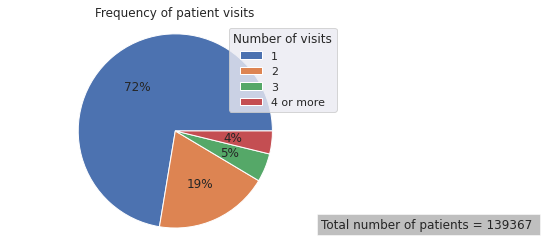

In [0]:
a=freq.numvisit[freq.numvisit==1].count()
b=freq.numvisit[freq.numvisit==2].count()
c=freq.numvisit[freq.numvisit==3].count()
d=freq.numvisit[freq.numvisit>=4].count()
visits = [a,b,c,d]


labels = '1','2','3','4 or more'
plt.pie(visits,autopct='%1.0f%%')
plt.title('Frequency of patient visits')
plt.legend(labels,title='Number of visits', loc ="best")
plt.text(1.5,-1.0,'Total number of patients = 139367 ',bbox=dict(facecolor='grey',alpha=0.5))
plt.axis('equal')
plt.show()

# Visualising some of the demographic factors (age,gender) of the patient table in eicu dataset :
## Data Pre-processing
### 1. Extract patient table from the dataset

In [0]:
%%bigquery --project $project_id patient
select * from `physionet-data.eicu_crd.patient`;

### 2. Clean the data extracted (treat missing and unknown values)

In [0]:
missing = patient[(patient['gender'] == '') |(patient['gender'] == 'Other')|(patient['gender'] == 'Unknown')| (patient['ethnicity'] == '')|(patient['ethnicity'] == 'Other/Unknown')|(patient['unitdischargestatus']=='')|(patient['hospitaldischargestatus']=='')|(patient['age']=='')].index
patient = patient.drop(index=missing)
patient

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
1,3036927,2462651,Male,51,Caucasian,420,1026,"Cardiovascular medical, other",177.8,19:38:00,-240,Emergency Department,2015,22:00:00,14302,Home,Alive,Med-Surg ICU,23:38:00,,1,admit,NaN,NaN,23:38:00,0,Other ICU,Alive,030-57208
2,3058863,2481889,Female,31,Caucasian,420,1026,Diabetic ketoacidosis,162.6,03:29:00,-292,Emergency Department,2015,23:00:00,879,Home,Alive,Med-Surg ICU,08:21:00,,1,admit,NaN,NaN,08:21:00,0,Other ICU,Alive,030-13634
3,3072720,2494105,Male,58,Caucasian,420,1026,,173.0,00:10:00,0,Other Hospital,2015,17:30:00,5360,Home,Alive,Med-Surg ICU,00:10:00,,1,admit,NaN,NaN,00:10:00,0,Other ICU,Alive,030-53536
4,3075429,2496542,Female,68,Caucasian,420,1026,,165.1,22:38:00,-1,Other Hospital,2014,23:05:00,12986,Death,Expired,Med-Surg ICU,22:39:00,,1,admit,NaN,NaN,22:39:00,0,Other ICU,Alive,030-59276
5,3076905,2497834,Female,51,Caucasian,420,1026,"ARDS-adult respiratory distress syndrome, non-...",165.1,01:32:00,0,Other Hospital,2015,06:11:00,279,Death,Expired,Med-Surg ICU,01:32:00,,1,admit,NaN,NaN,01:32:00,0,Other ICU,Alive,030-43695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200854,2096032,1661752,Female,47,Caucasian,307,766,Coma/change in level of consciousness (for hep...,149.9,11:03:00,-3570,,2015,20:40:00,11407,Death,Expired,Med-Surg ICU,22:33:00,Step-Down Unit (SDU),2,transfer,57.2,64.40,20:40:00,11407,Death,Expired,021-104956
200855,2122777,1682592,Female,46,Asian,307,766,Asthma,162.6,02:49:00,-1469,,2015,16:37:00,5119,Home,Alive,Med-Surg ICU,03:18:00,Step-Down Unit (SDU),3,admit,43.1,43.23,15:18:00,2160,Telemetry,Alive,021-39849
200856,2128239,1686820,Male,66,Caucasian,307,766,"Pneumonia, bacterial",190.5,04:23:54,-13812,,2014,00:47:00,21972,Skilled Nursing Facility,Alive,Med-Surg ICU,18:35:00,Step-Down Unit (SDU),2,transfer,86.4,NaN,20:23:00,4428,Acute Care/Floor,Alive,021-182987
200857,2179970,1726952,Male,69,Caucasian,307,766,GI obstruction,175.3,22:46:00,-11480,,2015,18:51:00,25725,Home,Alive,Med-Surg ICU,22:06:00,Step-Down Unit (SDU),4,admit,85.5,NaN,22:39:00,33,Step-Down Unit (SDU),Alive,021-249258


### 3. Convert datatype of age column to numeric from str

In [0]:
patient['age'].replace({'> 89': '89'}, inplace=True)
patient['age']=patient['age'].apply(pd.to_numeric)
patient['age']

1         51
2         31
3         58
4         68
5         51
          ..
200854    47
200855    46
200856    66
200857    69
200858    68
Name: age, Length: 187378, dtype: int64

# Visualisation of demographic factors


## 1. Extracting alive patients from the data.
## 2. Categorizing alive patients data based on the age groups like (15-19),(20-24), etc.

In [0]:
#Creating a label ages for plots
plt_ages=["15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80-84","85+"]
alive = patient[(patient.unitdischargestatus=='Alive')]
print(f'Highest age of an alive patient is {alive.age.max()},\nLowest age of an alive patient is {alive.age.min() }')
print(f'Unique age values are \n {alive.age.unique()}')

Highest age of an alive patient is 89,
Lowest age of an alive patient is 0
Unique age values are 
 [51 31 58 68 82 66 72 46 84 67 69 83 89 35 57 49 53 43 88 74 42 73 36 56
 38 44 18 78 77 70 76 71 85 65 61 24 47 60 54 45 87 79 81 55 20 52 80 62
 59 64 63 22 75 21 15 30 19 40 86 50 23 48 39 28 34 32 29 41 26 25 16  0
 10  1 37 27 33 17 13 14 12  3  2  7 11  9  8  5  4  6]


In [0]:
ages=range(15,86,5)
ages_upper = range(19, 90, 5)
#ages = [15, 20, 25...]
#ages_uppers = [19, 24, 29...]
alive_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(alive[(alive['age']>=age_l) & (alive['age']<=age_u)])
  alive_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Age Group 15-19 -> Count =1454
Age Group 20-24 -> Count =3566
Age Group 25-29 -> Count =4111
Age Group 30-34 -> Count =4702
Age Group 35-39 -> Count =5288
Age Group 40-44 -> Count =6686
Age Group 45-49 -> Count =9676
Age Group 50-54 -> Count =14442
Age Group 55-59 -> Count =17489
Age Group 60-64 -> Count =19133
Age Group 65-69 -> Count =20847
Age Group 70-74 -> Count =19978
Age Group 75-79 -> Count =17869
Age Group 80-84 -> Count =14887
Age Group 85-89 -> Count =16940


## 1. Extracting expired patients from the data.
## 2. Categorizing expired patients data based on the age groups like (15-19),(20-24), etc.

In [0]:
expired = patient[patient.unitdischargestatus=='Expired']
print(f'Highest age of an expired patient is {expired.age.max()} \nLowest age of an expired patient is {expired.age.min()}')
print(f'Unique age values of expired patients: \n{expired.age.unique()}')


Highest age of an expired patient is 89 
Lowest age of an expired patient is 14
Unique age values of expired patients: 
[64 88 63 85 83 57 84 80 51 66 86 58 89 78 59 55 47 70 82 69 67 73 34 81
 79 56 68 53 46 60 52 44 43 49 29 41 61 72 71 65 74 54 77 40 75 37 76 28
 23 62 38 50 87 25 39 32 36 48 42 30 33 21 35 31 45 27 26 24 18 20 22 19
 17 16 15 14]


In [0]:
print('Expired patient count based on age group')
exp_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(expired[(expired['age']>=age_l) & (expired['age']<=age_u)])
  exp_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Expired patient count based on age group
Age Group 15-19 -> Count =32
Age Group 20-24 -> Count =83
Age Group 25-29 -> Count =97
Age Group 30-34 -> Count =136
Age Group 35-39 -> Count =181
Age Group 40-44 -> Count =196
Age Group 45-49 -> Count =358
Age Group 50-54 -> Count =633
Age Group 55-59 -> Count =812
Age Group 60-64 -> Count =1074
Age Group 65-69 -> Count =1213
Age Group 70-74 -> Count =1260
Age Group 75-79 -> Count =1326
Age Group 80-84 -> Count =1249
Age Group 85-89 -> Count =1535


## Visual representation of admission frequencies of patients based on different age groups - 

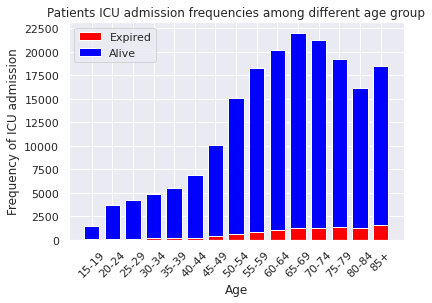

In [0]:
N=15
ind = np.arange(N)
#index = np.arange(len(ages))
#score_label = np.arange(0,12500,2500)
width = 0.75
p1 = plt.bar(plt_ages,exp_counts,width,color="red",label="Expired")
p2 = plt.bar(plt_ages,alive_counts,width,color="blue",label="Alive",bottom=exp_counts)
plt.xlabel('Age')
plt.ylabel('Frequency of ICU admission')
plt.title('Patients ICU admission frequencies among different age group')
plt.xticks(ind, plt_ages,rotation =45)
#plt.set_xticklabels(ages, rotation = 45, ha="right")
plt.yticks(np.arange(0, 25000, 2500))
plt.legend((p1[0], p2[0]), ('Expired', 'Alive'))
plt.show()

# Visualising expired patients based on gender


## 1. Extracting expired patients data from 'expired' dataframe based on gender.

In [0]:
female = expired[(expired.gender=='Female')]
male = expired[(expired.gender=='Male')]

### 2. Categorizing expired female data based on age groups.

In [0]:
print('Expired female patient count based on age group')
fem_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(female[(female['age']>=age_l) & (female['age']<=age_u)])
  fem_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Expired female patient count based on age group
Age Group 15-19 -> Count =12
Age Group 20-24 -> Count =27
Age Group 25-29 -> Count =40
Age Group 30-34 -> Count =48
Age Group 35-39 -> Count =70
Age Group 40-44 -> Count =90
Age Group 45-49 -> Count =147
Age Group 50-54 -> Count =277
Age Group 55-59 -> Count =353
Age Group 60-64 -> Count =444
Age Group 65-69 -> Count =590
Age Group 70-74 -> Count =539
Age Group 75-79 -> Count =616
Age Group 80-84 -> Count =598
Age Group 85-89 -> Count =821


### 3. Categorizing expired male data based on age groups.

In [0]:
print('Expired male patient count based on age group')
male_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(male[(male['age']>=age_l) & (male['age']<=age_u)])
  male_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Expired male patient count based on age group
Age Group 15-19 -> Count =20
Age Group 20-24 -> Count =56
Age Group 25-29 -> Count =57
Age Group 30-34 -> Count =88
Age Group 35-39 -> Count =111
Age Group 40-44 -> Count =106
Age Group 45-49 -> Count =211
Age Group 50-54 -> Count =356
Age Group 55-59 -> Count =459
Age Group 60-64 -> Count =630
Age Group 65-69 -> Count =623
Age Group 70-74 -> Count =721
Age Group 75-79 -> Count =710
Age Group 80-84 -> Count =651
Age Group 85-89 -> Count =714


### 4. Calculating mortality rate for this categorized data (for both male and female)


In [0]:
print('Mortality rate for female patients')
mor_fem =[]
for i in range(15):
  val = fem_counts[i]/len(expired)*100
  mor_fem.append(val)
  print(f'Mortality rate(%) for age group {plt_ages[i]} is {val}')

Mortality rate for female patients
Mortality rate(%) for age group 15-19 is 0.11780875711761242
Mortality rate(%) for age group 20-24 is 0.26506970351462794
Mortality rate(%) for age group 25-29 is 0.3926958570587081
Mortality rate(%) for age group 30-34 is 0.4712350284704497
Mortality rate(%) for age group 35-39 is 0.6872177498527391
Mortality rate(%) for age group 40-44 is 0.8835656783820931
Mortality rate(%) for age group 45-49 is 1.443157274690752
Mortality rate(%) for age group 50-54 is 2.719418810131553
Mortality rate(%) for age group 55-59 is 3.465540938543098
Mortality rate(%) for age group 60-64 is 4.3589240133516585
Mortality rate(%) for age group 65-69 is 5.792263891615943
Mortality rate(%) for age group 70-74 is 5.291576673866091
Mortality rate(%) for age group 75-79 is 6.047516198704104
Mortality rate(%) for age group 80-84 is 5.870803063027685
Mortality rate(%) for age group 85+ is 8.060082466129982


In [0]:
print('Mortality rate for male patients')
mor_male =[]
for i in range(15):
  val = male_counts[i]/len(expired)*100
  mor_male.append(val)
  print(f'Mortality rate(%) for age group {plt_ages[i]} is {val}')

Mortality rate for male patients
Mortality rate(%) for age group 15-19 is 0.19634792852935404
Mortality rate(%) for age group 20-24 is 0.5497741998821912
Mortality rate(%) for age group 25-29 is 0.559591596308659
Mortality rate(%) for age group 30-34 is 0.8639308855291578
Mortality rate(%) for age group 35-39 is 1.0897310033379146
Mortality rate(%) for age group 40-44 is 1.0406440212055763
Mortality rate(%) for age group 45-49 is 2.0714706459846846
Mortality rate(%) for age group 50-54 is 3.4949931278225015
Mortality rate(%) for age group 55-59 is 4.5061849597486745
Mortality rate(%) for age group 60-64 is 6.184959748674652
Mortality rate(%) for age group 65-69 is 6.116237973689378
Mortality rate(%) for age group 70-74 is 7.078342823483212
Mortality rate(%) for age group 75-79 is 6.970351462792069
Mortality rate(%) for age group 80-84 is 6.391125073630473
Mortality rate(%) for age group 85+ is 7.009621048497938


# Visualising patients ICU mortality rate per age group and gender -

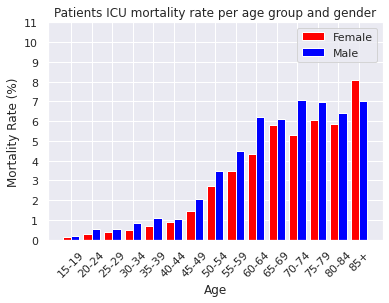

In [0]:
N=15
ind = np.arange(N)
#index = np.arange(len(ages))
#score_label = np.arange(0,12500,2500)
width = 0.4
#plt.grid()
p1 = plt.bar(ind,mor_fem,width,color="red",label="Female")
p2 = plt.bar(ind+width,mor_male,width,color="blue",label="Male")
plt.xlabel('Age')
plt.ylabel('Mortality Rate (%)')
plt.title('Patients ICU mortality rate per age group and gender')
plt.xticks(ind + width/2, plt_ages,rotation =45)
#plt.set_xticklabels(ages, rotation = 45, ha="right")
plt.yticks(np.arange(0.0, 11.5))
plt.legend((p1[0], p2[0]), ('Female', 'Male'))
plt.show()

# Visualising age distribution of expired patients based on gender - 

## Age distribution of patients who died in ICU based on gender 


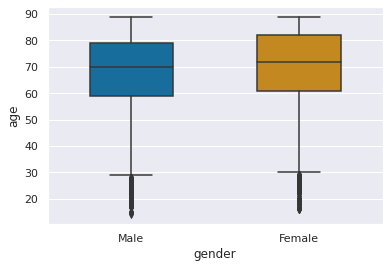

In [0]:
bplot = sns.boxplot(y='age', x='gender', 
                 data=expired, 
                 width=0.5,
                 palette="colorblind",)

# Extract ethnicity distribution of patients - 

In [0]:
race = patient[['uniquepid','ethnicity']]
race.uniquepid.drop_duplicates
race.sort_values(by=['uniquepid'])
race

,uniquepid,ethnicity
1,030-57208,Caucasian
2,030-13634,Caucasian
3,030-53536,Caucasian
4,030-59276,Caucasian
5,030-43695,Caucasian
...,...,...
200854,021-104956,Caucasian
200855,021-39849,Asian
200856,021-182987,Caucasian
200857,021-249258,Caucasian


In [0]:
## SQL QUERY (WE WILL NOT USE THIS HERE AS WE WILL CONTINUE TO WORK WITH OUR PROCESSED DATA
#%%bigquery --project $project_id race
#select uniquepid, ethnicity
#from `physionet-data.eicu_crd.patient` 
#group by uniquepid,ethnicity
#order by uniquepid;

## 1. Finding number of each patients for each ethnicity

In [0]:
race_count = []
races = ['Native American','Asian','Hispanic','African American','Caucasian']
for x in races:
  val=race.ethnicity[race.ethnicity==x].count()
  race_count.append(val)
  print(f'Race count for {x} : {val}')

Race count for Native American : 1688
Race count for Asian : 3221
Race count for Hispanic : 7426
Race count for African American : 21127
Race count for Caucasian : 153916


## Visualising ethnicity distribution of patients using pie chart

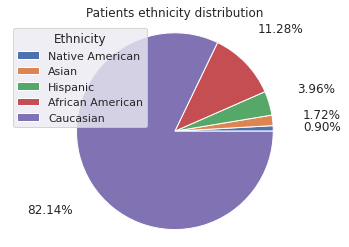

In [0]:
plt.pie(race_count,autopct='%1.2f%%',pctdistance=1.5,labeldistance = 2)
plt.title('Patients ethnicity distribution')
plt.legend(races,title='Ethnicity', loc ="best")
plt.axis('equal')
plt.show()

# Visualising ICU mortality rate per age group and ethnicity -

## 1. Extracting expired patients data based on ethnicity

In [0]:
aa = expired[(expired.ethnicity=='African American')]
print('Total deaths in African American patients:',len(aa))
ca = expired[(expired.ethnicity=='Caucasian')]
print('Total deaths in Caucasian patients:',len(ca))

Total deaths in African American patients: 1151
Total deaths in Caucasian patients: 8399


### 2. Categorising this extracted data as per age groups for African Americans -


In [0]:
print('Expired African American patient count based on age group')
aa_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(aa[(aa['age']>=age_l) & (aa['age']<=age_u)])
  aa_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Expired African American patient count based on age group
Age Group 15-19 -> Count =5
Age Group 20-24 -> Count =17
Age Group 25-29 -> Count =14
Age Group 30-34 -> Count =36
Age Group 35-39 -> Count =33
Age Group 40-44 -> Count =49
Age Group 45-49 -> Count =63
Age Group 50-54 -> Count =99
Age Group 55-59 -> Count =118
Age Group 60-64 -> Count =142
Age Group 65-69 -> Count =150
Age Group 70-74 -> Count =124
Age Group 75-79 -> Count =113
Age Group 80-84 -> Count =89
Age Group 85-89 -> Count =99


### 3. Categorising this extracted data as per age groups for Caucasians -


In [0]:
print('Expired Caucasian patient count based on age group')
ca_counts = []
for age_l, age_u in zip(ages, ages_upper):
  count = len(ca[(ca['age']>=age_l) & (ca['age']<=age_u)])
  ca_counts.append(count)
  print(f'Age Group {age_l}-{age_u} -> Count ={count}')

Expired Caucasian patient count based on age group
Age Group 15-19 -> Count =23
Age Group 20-24 -> Count =58
Age Group 25-29 -> Count =72
Age Group 30-34 -> Count =87
Age Group 35-39 -> Count =124
Age Group 40-44 -> Count =127
Age Group 45-49 -> Count =264
Age Group 50-54 -> Count =478
Age Group 55-59 -> Count =643
Age Group 60-64 -> Count =870
Age Group 65-69 -> Count =1013
Age Group 70-74 -> Count =1088
Age Group 75-79 -> Count =1139
Age Group 80-84 -> Count =1080
Age Group 85-89 -> Count =1332


### 4. Calculating mortality rate for the categorised data  - (for both African American and Caucasian patients)

In [0]:
print('Mortality rate(%) for African Americans for each age group')
mor_aa =[]
for i in range(15):
  val = aa_counts[i]/len(expired)*100
  mor_aa.append(val)
  print(f'Mortality rate(%) for age group {plt_ages[i]} is {val}')

Mortality rate(%) for African Americans for each age group
Mortality rate(%) for age group 15-19 is 0.04908698213233851
Mortality rate(%) for age group 20-24 is 0.16689573924995094
Mortality rate(%) for age group 25-29 is 0.1374435499705478
Mortality rate(%) for age group 30-34 is 0.3534262713528373
Mortality rate(%) for age group 35-39 is 0.32397408207343414
Mortality rate(%) for age group 40-44 is 0.48105242489691735
Mortality rate(%) for age group 45-49 is 0.6184959748674651
Mortality rate(%) for age group 50-54 is 0.9719222462203023
Mortality rate(%) for age group 55-59 is 1.1584527783231886
Mortality rate(%) for age group 60-64 is 1.3940702925584134
Mortality rate(%) for age group 65-69 is 1.472609463970155
Mortality rate(%) for age group 70-74 is 1.217357156881995
Mortality rate(%) for age group 75-79 is 1.1093657961908503
Mortality rate(%) for age group 80-84 is 0.8737482819556254
Mortality rate(%) for age group 85+ is 0.9719222462203023


In [0]:
print('Mortality rate(%) for Caucasians for each age group')
mor_ca =[]
for i in range(15):
  val = ca_counts[i]/len(expired)*100
  mor_ca.append(val)
  print(f'Mortality rate(%) for age group {plt_ages[i]} is {val}')

Mortality rate(%) for Caucasians for each age group
Mortality rate(%) for age group 15-19 is 0.2258001178087571
Mortality rate(%) for age group 20-24 is 0.5694089927351267
Mortality rate(%) for age group 25-29 is 0.7068525427056745
Mortality rate(%) for age group 30-34 is 0.85411348910269
Mortality rate(%) for age group 35-39 is 1.217357156881995
Mortality rate(%) for age group 40-44 is 1.2468093461613978
Mortality rate(%) for age group 45-49 is 2.591792656587473
Mortality rate(%) for age group 50-54 is 4.692715491851561
Mortality rate(%) for age group 55-59 is 6.312585902218731
Mortality rate(%) for age group 60-64 is 8.5411348910269
Mortality rate(%) for age group 65-69 is 9.94502258001178
Mortality rate(%) for age group 70-74 is 10.68132731199686
Mortality rate(%) for age group 75-79 is 11.182014529746711
Mortality rate(%) for age group 80-84 is 10.602788140585115
Mortality rate(%) for age group 85+ is 13.076772040054976


# Visualisation of mortality rate per age group and ethnicity-

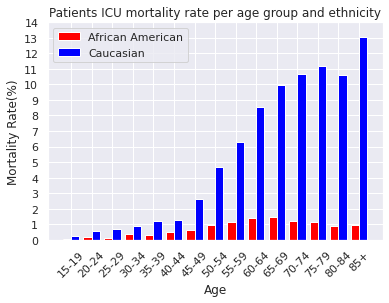

In [0]:
N=15
ind = np.arange(N)
#index = np.arange(len(ages))
#score_label = np.arange(0,12500,2500)
width = 0.4
p1 = plt.bar(ind,mor_aa,width,color="red",label="African American")
p2 = plt.bar(ind+width,mor_ca,width,color="blue",label="Caucasian")
plt.xlabel('Age')
plt.ylabel('Mortality Rate(%)')
plt.title('Patients ICU mortality rate per age group and ethnicity')
plt.xticks(ind + width/2, plt_ages,rotation =45)
#plt.set_xticklabels(ages, rotation = 45, ha="right")
plt.yticks(np.arange(0,15))
plt.legend((p1[0], p2[0]), ('African American', 'Caucasian'))
plt.show()

# Visualisation depicting age distribution of patients who died in ICU based on different ethnic groups

[Text(0, 0, 'Caucasian'),
 Text(0, 0, 'African American'),
 Text(0, 0, 'Hispanic'),
 Text(0, 0, 'Asian'),
 Text(0, 0, 'Native American')]

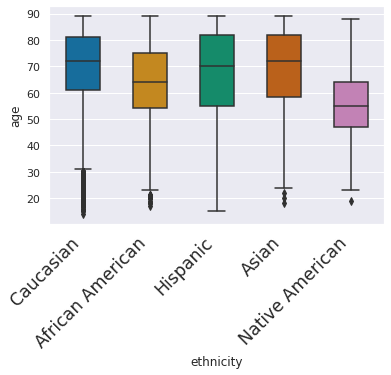

In [0]:
bplot = sns.boxplot(y='age', x='ethnicity', 
                 data=expired, 
                 width=0.5,
                 palette="colorblind")
bplot.set_xticklabels(bplot.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize='x-large',fontweight='light')
#bplot.xticks(rotation=45)

# Dataframe that includes total deaths and mortality rate for each age group based on ethnicity -

In [0]:
table1={'Age column':plt_ages,'Caucasian Death #':ca_counts,'Caucasian Mortality Rate':mor_ca,'African American Death#':aa_counts,'African American Mortality Rate':mor_aa}
table1_df=pd.DataFrame(table1)
table1_df

,Age column,Caucasian Death #,Caucasian Mortality Rate,African American Death#,African American Mortality Rate
0,15-19,23,0.225800,5,0.049087
1,20-24,58,0.569409,17,0.166896
2,25-29,72,0.706853,14,0.137444
3,30-34,87,0.854113,36,0.353426
4,35-39,124,1.217357,33,0.323974
5,40-44,127,1.246809,49,0.481052
6,45-49,264,2.591793,63,0.618496
7,50-54,478,4.692715,99,0.971922
8,55-59,643,6.312586,118,1.158453
9,60-64,870,8.541135,142,1.394070


# Query to find most frequent diseases with highest mortality rates based on ICU discharge status - (TOP 20) 

## *Note - There are 2 types of discharge status in the dataset - ICU and hospital 

In [0]:
%%bigquery --project $project_id topdiseases_death
select apacheadmissiondx, count(apacheadmissiondx) as count,count(apacheadmissiondx)*100/(select count(*) from `physionet-data.eicu_crd.patient` where unitdischargestatus='Expired') as morpct
from `physionet-data.eicu_crd.patient` 
where unitdischargestatus='Expired'
group by apacheadmissiondx 
order by count(apacheadmissiondx) desc
limit 20;

In [0]:
topdiseases_death.columns=['Disease','Patients(#)','Mortality(%)']
topdiseases_death


,Disease,Patients(#),Mortality(%)
0,Cardiac arrest (with or without respiratory ar...,1900,17.420006
1,"Sepsis, pulmonary",1068,9.791877
2,,692,6.344549
3,"Sepsis, GI",391,3.584854
4,"CHF, congestive heart failure",357,3.273127
5,"Pneumonia, bacterial",332,3.043917
6,"Sepsis, renal/UTI (including bladder)",331,3.034748
7,"CVA, cerebrovascular accident/stroke",331,3.034748
8,"Arrest, respiratory (without cardiac arrest)",330,3.025580
9,"Sepsis, unknown",318,2.915559


# Query to find most frequent diseases with highest mortality rates based on hospital discharge status - (TOP 20) 

In [0]:
%%bigquery --project $project_id topdiseases_hospdeath
select apacheadmissiondx, count(apacheadmissiondx) as count,count(apacheadmissiondx)*100/(select count(*) from `physionet-data.eicu_crd.patient` where hospitaldischargestatus='Expired') as morpct
from `physionet-data.eicu_crd.patient` 
where hospitaldischargestatus='Expired'
group by apacheadmissiondx 
order by count(apacheadmissiondx) desc
limit 20;

In [0]:
topdiseases_hospdeath.columns=['Disease','Patients(#)','Mortality(%)']
topdiseases_hospdeath

,Disease,Patients(#),Mortality(%)
0,Cardiac arrest (with or without respiratory ar...,2345,13.024883
1,"Sepsis, pulmonary",1641,9.114641
2,,1481,8.225950
3,"CHF, congestive heart failure",683,3.793601
4,"CVA, cerebrovascular accident/stroke",662,3.676961
5,"Sepsis, renal/UTI (including bladder)",591,3.282604
6,"Pneumonia, bacterial",585,3.249278
7,"Sepsis, GI",579,3.215952
8,"Arrest, respiratory (without cardiac arrest)",566,3.143746
9,"Sepsis, unknown",480,2.666074
